In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [2]:
tile_size = 320
threshold = 3000

random_pattern = True
# number of PEs compute in the same time
num_PE = 64
Band = 32

In [3]:
W = {'A': {'A':  91, 'C': -90, 'G': -25, 'T':-100},
     'C': {'A': -90, 'C': 100, 'G':-100, 'T': -25},
     'G': {'A': -25, 'C':-100, 'G': 100, 'T': -90},
     'T': {'A':-100, 'C': -25, 'G': -90, 'T':  91}}
g_o = -430
g_e = -30

In [4]:
# W = {'A': {'A': 2, 'C':-3, 'G':-3, 'T':-3},
#      'C': {'A':-3, 'C': 2, 'G':-3, 'T':-3},
#      'G': {'A':-3, 'C':-3, 'G': 2, 'T':-3},
#      'T': {'A':-3, 'C':-3, 'G':-3, 'T': 2}}
# g_o = -7
# g_e = -2

In [5]:
f = open('sequence_1.txt', 'r')
gene_1 = ''
f.readline()
for line in f.readlines():
    gene_1 = gene_1 + line[:-1]
f.close()

f = open('sequence_2.txt', 'r')
gene_2 = ''
f.readline()
for line in f.readlines():
    gene_2 = gene_2 + line[:-1]
f.close()

print(len(gene_1), len(gene_2))

607 763


In [6]:
bias = 0
gene_1, gene_2 = gene_1[bias:bias+tile_size], gene_2[bias:bias+tile_size]
print(len(gene_1), len(gene_2))
print(gene_1)
print(gene_2)

320 320
ATGTTCTCTCGGAGGATGTATTATCTTTTGCTCATTCTAAGCACAATGCTTTCTTTCCACCTTGTGGAGGGGATTTTGGAAAATGTGCTAGCCCGTTCTACAAGTAAGAATTGATATTGATGCATTCTAAATGTAAATACATGATTTACAGCTGTCATCGTTGTATTCTATGTTATTACCAATTCAGCATATTAGCATAATATCTACATATATTTAATTCAGTATCGATTTATTTGCTTTAGTTGTGTAAAACACCCCGTTCTATGCATTACCTTGTCGCATTTGAATTCAGTAATCTTTATTTAAATGTTTTTAACTGT
ATGTTCTCTCGGAGGATTTATTATCTTTTGCTCATTTTAAGCACAATGCTTTCTTTTCACCTTGTGGAGGGGATTTTGGAAAATGTGCTAGCCCGTTCTACAAGTAAGAATTGATATTGATGCATTCTAAATGCAAATACATGATTTACAACTGTCATCGTTGTATTCTATGTTATTACCAATTCAGCATATTAGCATTATATCTACATATATTTAATTCAGTATCGATTTATTTGCTTTCGTTGTGTAAAACACCCTGTTCTATGCATTGCCTTGACGCATTTGAATTCAGTAATCTTTATTTAAATGTTTTTAACTGT


In [7]:
import random
random.seed(10)

d = ['A', 'C', 'G', 'T']
if random_pattern:
    gene_1, gene_2 = '', ''
    for i in range(tile_size):
        gene_1 += d[random.randint(0, 3)]
    i = 0
    while i < tile_size:
        die = random.random()
        l = random.randint(1,8)
        # delete gene_1 for length l
        if die < 0.05:
            i += l
        # insert gene_1 for length l
        elif die < 0.1:
            for j in range(l):
                gene_2 += d[random.randint(0, 3)]
            i += 1
        # change 1 gene
        elif die < 0.15:
            gene_2 += d[random.randint(0, 3)]
            i += 1
        else:
            gene_2 += gene_1[i]
            i += 1
    while len(gene_2) < tile_size:
        gene_2 += d[random.randint(0, 3)]
            
    print(len(gene_1), len(gene_2))
    print(gene_1)
    print(gene_2)

320 320
ATTACTTGCATGACGATCGTTGGTCGGCTCTTAACCCGGCGTTTAGCCTCAATGAACTGCAATCCGTTTCGCCAGTGCCCTGGTCAAGGCAGTTCTTCGTTACTTTCTGTTCTATAATAAGACATTCTTTGGTTGCCGACTAAGTCGAAAGCTCGTCGCACTCAGTTTCGGAACTTTCATAAGGGTTCGTGTGTTGGGTTTTAGTCTAGAGGATGGCCCGAACATCTATCGCGAAAGTGCCAGCAGATTGACTTTTCGTGTTCATCACCTGTAACGCACAGCGATTAGCTCCTTGACCTCTATACATGGAGTCGACTCAT
CGGACAATATGATCGTAGATTAACTAGCCACAATGAACTGCAAGTTTCGCGAGTGGCCTGGTCAAGGCATACATCCTTCGGAGGATTCGTAACTTTCTGTTCTATAATAAGGCCACTGTGGTTGGCGACTAAGTCGAAAGCTCGTCGCACTCAGTTTCGGAACTTTCATAAGGGTTCGCATAAGTTTTAGTCTAGAGGCAGTGGAACTCGCCTATCGCGAATGTGCCAGCAGATTGTTTGTTCATCCCCTGTACACAGCGATTTCCTTGCCTGGCGAGAGAGCGACTCATGTATCCTGGCTAACTCCAAGGACAAATCAT


In [8]:
# tile_size = 52
# gene_1 = gene_1[:tile_size]
# gene_2 = gene_2[:tile_size]
# print(gene_1)
# print(gene_2)

# Normal version

In [9]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no previous, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Insertion matrix (Score when direction is left)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Deletion matrix (Score when direction is top)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
V_max = float('-inf')
x_max, y_max = 0, 0
i,j = 1,1
print(V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]])
print(V[i][j-1]+g_o, I[i][j-1]+g_e)
print(V[i-1][j]+g_o, D[i-1][j]+g_e)

for i in range(1, tile_size+1):
    for j in range(1, tile_size+1):
        V_nxt = V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]]
        I[i][j] = max(V[i][j-1]+g_o, I[i][j-1]+g_e, 0)
        D[i][j] = max(V[i-1][j]+g_o, D[i-1][j]+g_e, 0)
        V[i][j] = max(V_nxt, I[i][j], D[i][j], 0)
        # if new maximum
        if V[i][j] >= V_max:
            V_max = V[i][j]
            x_max, y_max = i, j
        # direction of Trace
        if V[i][j] == 0:
            Trace[i][j] = 0
        elif V[i][j] == V_nxt:
            Trace[i][j] = 1
        elif V[i][j] == D[i][j]:
            Trace[i][j] = 2
        elif V[i][j] == I[i][j]:
            Trace[i][j] = 3
        # direction of Trace_I
        if I[i][j] == V[i][j-1]+g_o:
            Trace_I[i][j] = 1
        else:
            Trace_I[i][j] = 0
        # direction of Trace_D
        if D[i][j] == V[i-1][j]+g_o:
            Trace_D[i][j] = 1
        else:
            Trace_D[i][j] = 0
    # print(V_max)
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print('Direction of I')
print(Trace_D)
print('Direction of D')
print(Trace_I)
print(V_max, x_max, y_max)

-90.0
-430.0 -30.0
-430.0 -30.0
Score matrix
[[    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.    91.     0.]
 [    0.     0.     0. ...     0.     0.   182.]
 ...
 [    0.   100.     0. ... 12169. 11879. 11852.]
 [    0.     0.    75. ... 11891. 12260. 11831.]
 [    0.     0.     0. ... 12012. 11982. 12351.]]
Insertion matrix (Score when direction is left)
[[    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... 11909. 11879. 11849.]
 [    0.     0.     0. ... 11891. 11861. 11831.]
 [    0.     0.     0. ... 12012. 11982. 11952.]]
Deletion matrix (Score when direction is top)
[[    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... 11517. 11447. 11368.]
 [    0.     0.     0. ... 11739. 11449. 11422.]
 [    0.   

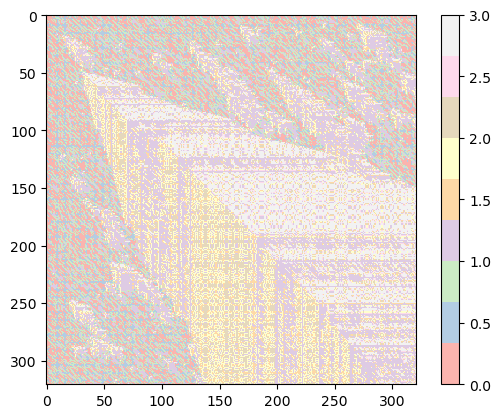

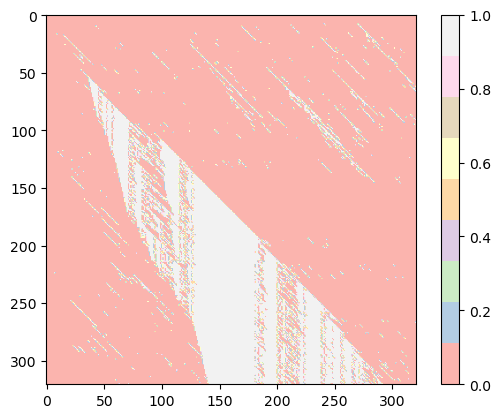

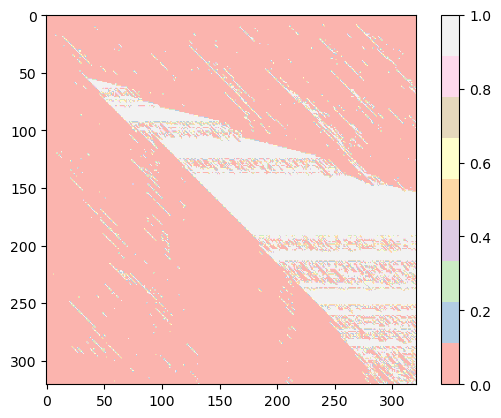

In [11]:
Trace_ans = Trace
Trace_I_ans = Trace_I
Trace_D_ans = Trace_D
plt.imshow(Trace[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()
plt.imshow(Trace_I[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()
plt.imshow(Trace_D[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

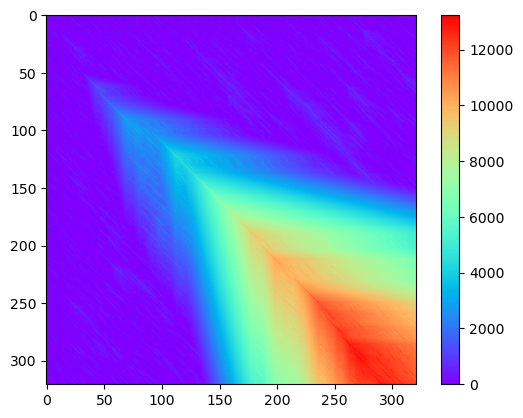

Score: 13252.0 Position: (320, 290)


In [12]:
V_ans = V
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.show()
print('Score:', V_max, f'Position: {x_max, y_max}')

In [13]:
seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'
start_position = 0, 0

x, y = x_max, y_max
while(x != 0) and (y != 0):
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y)
        if Trace[x][y] == 0:
            break
        elif Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1
    start_position = x, y

width = 60
parts = len(seq_1)//width + 1
print(f'Score: {V_max}, Position: {x_max, y_max}, Start: {start_position}')
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

seq_1_ans = seq_1
seq_2_ans = seq_2
result_ans = result

Score: 13252.0, Position: (320, 290), Start: (43, 24)
TAGCCTCAATGAACTGCAATCCGTTTCGCCAGTGCCCTGGTCAAGGCAG------TTC--
||||| |||||||||||||   ||||||| |||| |||||||||||||       |||  
TAGCCACAATGAACTGCAA---GTTTCGCGAGTGGCCTGGTCAAGGCATACATCCTTCGG

----TTCGTTACTTTCTGTTCTATAATAAGACATTCTTTGGTTGCCGACTAAGTCGAAAG
    ||||| |||||||||||||||||||| |   || |||||| |||||||||||||||
AGGATTCGTAACTTTCTGTTCTATAATAAGGC-CACTGTGGTTGGCGACTAAGTCGAAAG

CTCGTCGCACTCAGTTTCGGAACTTTCATAAGGGTTCGTGTGTTGGGTTTTAGTCTAGAG
||||||||||||||||||||||||||||||||||||||     |  ||||||||||||||
CTCGTCGCACTCAGTTTCGGAACTTTCATAAGGGTTCGCA---TAAGTTTTAGTCTAGAG

GATGGCCCGAACATCTATCGCGAAAGTGCCAGCAGATTGACTTTTCGTGTTCATCACCTG
|  |       |  |||||||||| ||||||||||||||        |||||||| ||||
GCAGTGGAACTCGCCTATCGCGAATGTGCCAGCAGATTG------TTTGTTCATCCCCTG

TAACGCACAGCGATTAGCTCCTTGACCTCTATACATGGAGTCGACTCAT
||   ||||||||||   |||||| |       |  |    ||||||||
TA---CACAGCGATT---TCCTTGCCT----GGCGAGAGAGCGACTCAT



In [14]:
# checking calculation
score = 0
for i in range(len(seq_1)):
    if seq_1[i] == '-':
        if seq_1[i-1] == '-':
            score += g_e
        else:
            score += g_o
    elif seq_2[i] == '-':
        if seq_2[i-1] == '-':
            score += g_e
        else:
            score += g_o
    else:
        score += W[seq_1[i]][seq_2[i]]
print(score)

13252


# With stripe (banded)

In [15]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))

print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Insertion matrix (Score when direction is left)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Deletion matrix (Score when direction is top)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
# start position of next PE stripe
column_start = 1
column_end = 1
V_max = 0
x_max, y_max = 0, 0

for i in range(1, tile_size+1, num_PE):
    column_start = max(1, (i//num_PE)*num_PE+1-Band)
    column_end = min(tile_size, (i//num_PE+1)*num_PE+Band)
    column = column_start # current row
    print(column_start, column_end)
    while column <= column_end:
        # row index: i+j, column index:column
        for j in range(num_PE):
            if i+j > tile_size:
                break
            # print(i+j, column)
            V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
            I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e, 0)
            D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e, 0)
            V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column], 0)
            # print(i+j, column, V[i+j][column])
            # track max score
            if V[i+j][column] >= V_max:
                V_max = V[i+j][column]
                x_max, y_max = i+j, column
            # track direction
            if V[i+j][column] == 0:
                Trace[i+j][column] = 0
            elif V[i+j][column] == V_nxt:
                Trace[i+j][column] = 1
            elif V[i+j][column] == D[i+j][column]:
                Trace[i+j][column] = 2
            elif V[i+j][column] == I[i+j][column]:
                Trace[i+j][column] = 3
            # direction of Trace_I
            if I[i+j][column] == V[i+j][column-1]+g_o:
                Trace_I[i+j][column] = 1
            else:
                Trace_I[i+j][column] = 0
            # direction of Trace_D
            if D[i+j][column] == V[i+j-1][column]+g_o:
                Trace_D[i+j][column] = 1
            else:
                Trace_D[i+j][column] = 0
        # if stripe end
        column += 1

print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print(V_max, x_max, y_max)

1 96
33 160
97 224
161 288
225 320
Score matrix
[[    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... 12169. 11879. 11852.]
 [    0.     0.     0. ... 11891. 12260. 11831.]
 [    0.     0.     0. ... 12012. 11982. 12351.]]
Insertion matrix (Score when direction is left)
[[    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... 11909. 11879. 11849.]
 [    0.     0.     0. ... 11891. 11861. 11831.]
 [    0.     0.     0. ... 12012. 11982. 11952.]]
Deletion matrix (Score when direction is top)
[[    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 [    0.     0.     0. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... 11517. 11447. 11368.]
 [    0.     0.     0. ... 11739. 11449. 11422.]
 [    0.

In [17]:
def SW(gene_1, gene_2, W, g_o, g_e):
    # Initial
    tile_size = min(len(gene_1), len(gene_1))
    V = np.zeros((tile_size+1, tile_size+1))
    I = np.zeros((tile_size+1, tile_size+1))
    D = np.zeros((tile_size+1, tile_size+1))
    Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
    Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
    Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)
    V_max = float('-inf')
    x_max, y_max = 0, 0
    # Calculate
    column_start = 1
    column_end = 1
    V_max = 0
    x_max, y_max = 0, 0

    for i in range(1, tile_size+1, num_PE):
        column_start = max(1, (i//num_PE)*num_PE+1-Band)
        column_end = min(tile_size, (i//num_PE+1)*num_PE+Band)
        column = column_start # current row
        while column <= column_end:
            # row index: i+j, column index:column
            for j in range(num_PE):
                if i+j > tile_size:
                    break
                V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
                I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e, 0)
                D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e, 0)
                V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column], 0)
                # track max score
                if V[i+j][column] >= V_max:
                    V_max = V[i+j][column]
                    x_max, y_max = i+j, column
                # track direction
                if V[i+j][column] == 0:
                    Trace[i+j][column] = 0
                elif V[i+j][column] == V_nxt:
                    Trace[i+j][column] = 1
                elif V[i+j][column] == D[i+j][column]:
                    Trace[i+j][column] = 2
                elif V[i+j][column] == I[i+j][column]:
                    Trace[i+j][column] = 3
                # direction of Trace_I
                if I[i+j][column] == V[i+j][column-1]+g_o:
                    Trace_I[i+j][column] = 1
                else:
                    Trace_I[i+j][column] = 0
                # direction of Trace_D
                if D[i+j][column] == V[i+j-1][column]+g_o:
                    Trace_D[i+j][column] = 1
                else:
                    Trace_D[i+j][column] = 0
            # if stripe end
            column += 1
    return V_max

In [18]:
v_test = SW(gene_1, gene_2, W, g_o, g_e)
print(v_test)

13252.0


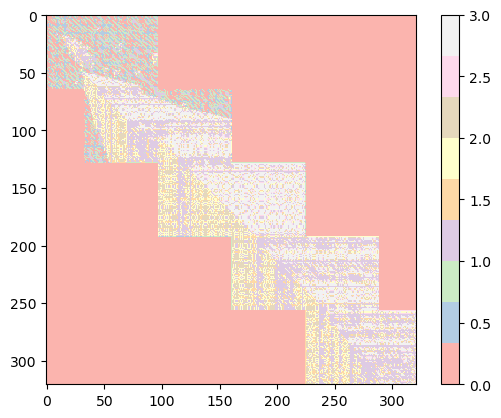

In [19]:
plt.imshow(Trace[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

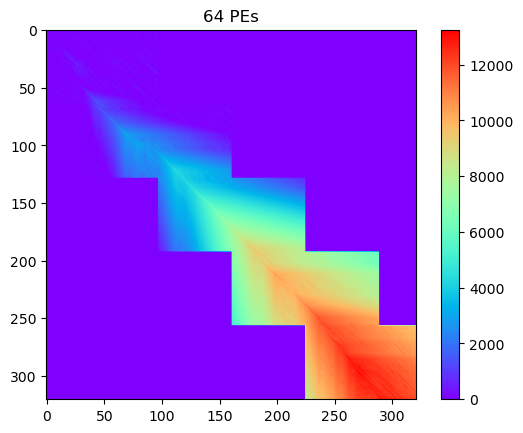

Score: 13252.0 Position: (320, 290)


In [20]:
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.title(f'{num_PE} PEs')
plt.show()
print('Score:', V_max, f'Position: {x_max, y_max}')

In [21]:
seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'
start_position = 0, 0

x, y = x_max, y_max
while(x != 0) and (y != 0):
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y)
        if Trace[x][y] == 0:
            break
        elif Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1
    start_position = x, y

width = 60
parts = len(seq_1)//width + 1
print(f'Score: {V_max}, Position: {x_max, y_max}, Start: {start_position}')
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

print(seq_1 == seq_1_ans)
print(seq_2 == seq_2_ans)

Score: 13252.0, Position: (320, 290), Start: (43, 24)
TAGCCTCAATGAACTGCAATCCGTTTCGCCAGTGCCCTGGTCAAGGCAG------TTC--
||||| |||||||||||||   ||||||| |||| |||||||||||||       |||  
TAGCCACAATGAACTGCAA---GTTTCGCGAGTGGCCTGGTCAAGGCATACATCCTTCGG

----TTCGTTACTTTCTGTTCTATAATAAGACATTCTTTGGTTGCCGACTAAGTCGAAAG
    ||||| |||||||||||||||||||| |   || |||||| |||||||||||||||
AGGATTCGTAACTTTCTGTTCTATAATAAGGC-CACTGTGGTTGGCGACTAAGTCGAAAG

CTCGTCGCACTCAGTTTCGGAACTTTCATAAGGGTTCGTGTGTTGGGTTTTAGTCTAGAG
||||||||||||||||||||||||||||||||||||||     |  ||||||||||||||
CTCGTCGCACTCAGTTTCGGAACTTTCATAAGGGTTCGCA---TAAGTTTTAGTCTAGAG

GATGGCCCGAACATCTATCGCGAAAGTGCCAGCAGATTGACTTTTCGTGTTCATCACCTG
|  |       |  |||||||||| ||||||||||||||        |||||||| ||||
GCAGTGGAACTCGCCTATCGCGAATGTGCCAGCAGATTG------TTTGTTCATCCCCTG

TAACGCACAGCGATTAGCTCCTTGACCTCTATACATGGAGTCGACTCAT
||   ||||||||||   |||||| |       |  |    ||||||||
TA---CACAGCGATT---TCCTTGCCT----GGCGAGAGAGCGACTCAT

True
True
